# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
# Importación de bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


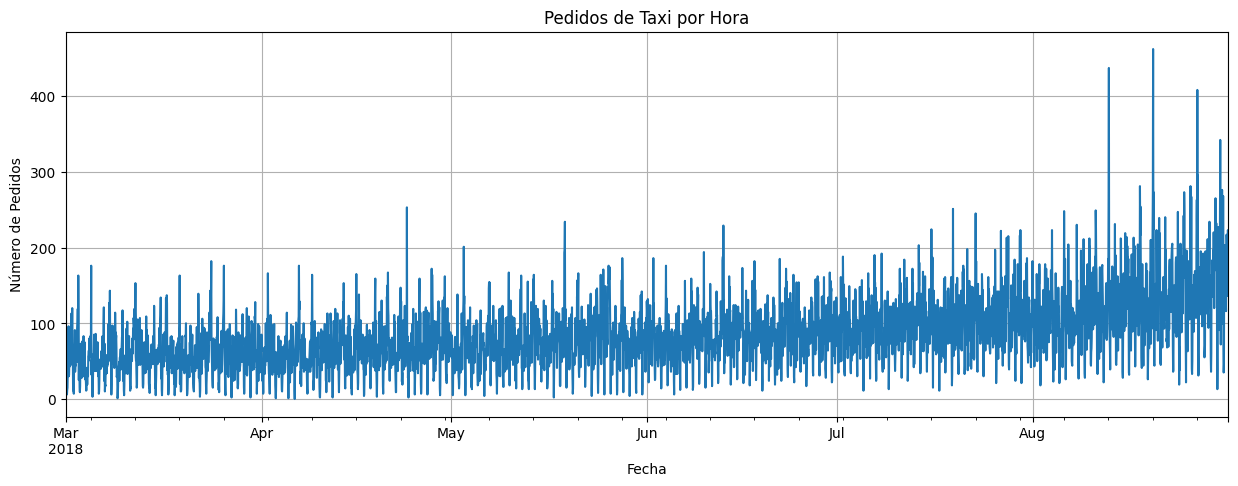

In [2]:
# 1. Cargar datos
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

data.info()
data.head()
# Paso 2: Remuestreo por hora
data_resample = data.resample('1H').sum()
print(data_resample.head())

# Gráfico para análisis visual
plt.figure(figsize=(15, 5))
data_resample['num_orders'].plot()
plt.title('Pedidos de Taxi por Hora')
plt.xlabel('Fecha')
plt.ylabel('Número de Pedidos')
plt.grid()
plt.show()


**Observaciones**

Observamos que el dataset consta de 26,496 registros con una sola columna *num_orders*. No hay valores ausentes. 

Remuestreamos el dataset con pedidos de taxi por hora.

Graficamos el dataset remuestreado y notamos que conforme va avanzando el año, hay más pedidos de taxis.


## Análisis

In [3]:
# Verificamos si los datos están en orden
print(data_resample.index.is_monotonic)


True


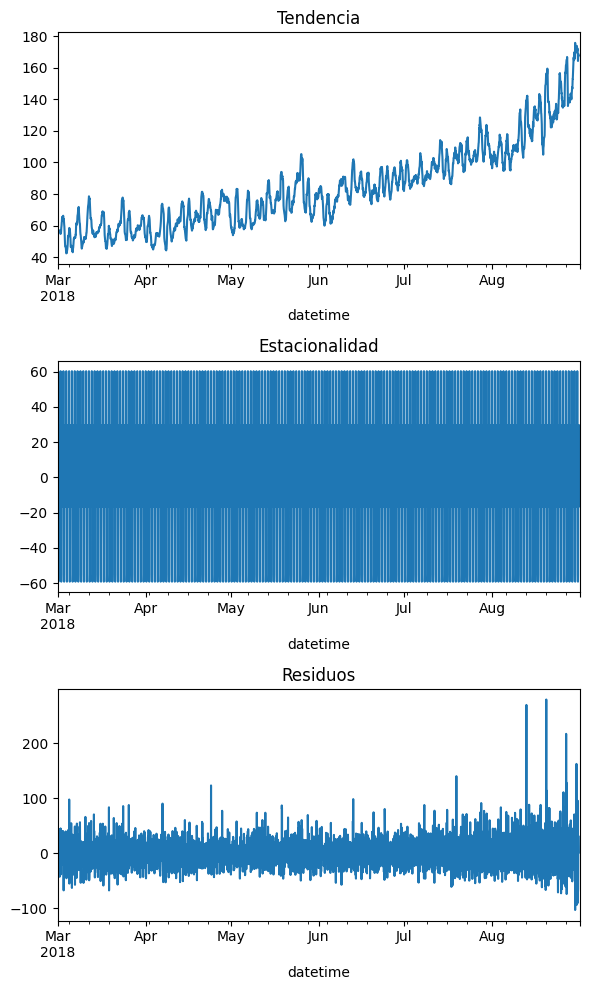

In [4]:

decomposed = seasonal_decompose(data_resample)
plt.figure(figsize=(6, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuos')
plt.tight_layout()

In [11]:
# Verificamos si la serie es o no estacionaria

def adf_test(serie, title=''):
    print(f'ADF Test: {title}')
    result = adfuller(serie.dropna())
    print(f'Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] < 0.05:
        print('La serie ES estacionaria.\n')
    else:
        print('La serie NO es estacionaria.\n')

# Prueba ADF en serie
adf_test(data_resample['num_orders'], title='Serie Original')



ADF Test: Serie Original
Statistic: -3.0689
p-value: 0.0289
La serie ES estacionaria.



**Observaciones**

Verificamos si el dataset se encontraba en order cronológico con *index.is_monotonic* y nos arrojó que sí están en order cronológico. 

Por otro lado, podemos observar que en la descomposición del dataset, que la tendencia es de crecimiento conforme va avanzando el año. La estacionalidad es estable alrededor de 0 (por lo que podemos decir que la series es estacionaria) y los residuos, están concentrados alrededor de 0. Aunque podemos observar que la serie es estacionaria, verificamos con la prueba Dickey-Fuller. 

La prueba nos arrojó que la serie es estacionaria pues el valor de p es 0 (< 0.05) por lo que podemos proceder al modelado y pronótico.

In [12]:
# Crear características de desfase (lags). Por default, tomaremos un desfase de tamaño 23
def create_lag_features(data, lag=3):
    for lag in range(1, lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(7).mean()
    return data.dropna()

# Desfase
lag = 23
data_lag = create_lag_features(data_resample, lag)

# Separar características y objetivo
X = data_lag.drop('num_orders', axis=1)
y = data_lag['num_orders']

# Dividir en entrenamiento y prueba (último 10% como prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False)



## Formación

In [8]:
# Modelo: Regresión Lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)


## Prueba

RMSE en conjunto de prueba: 45.41


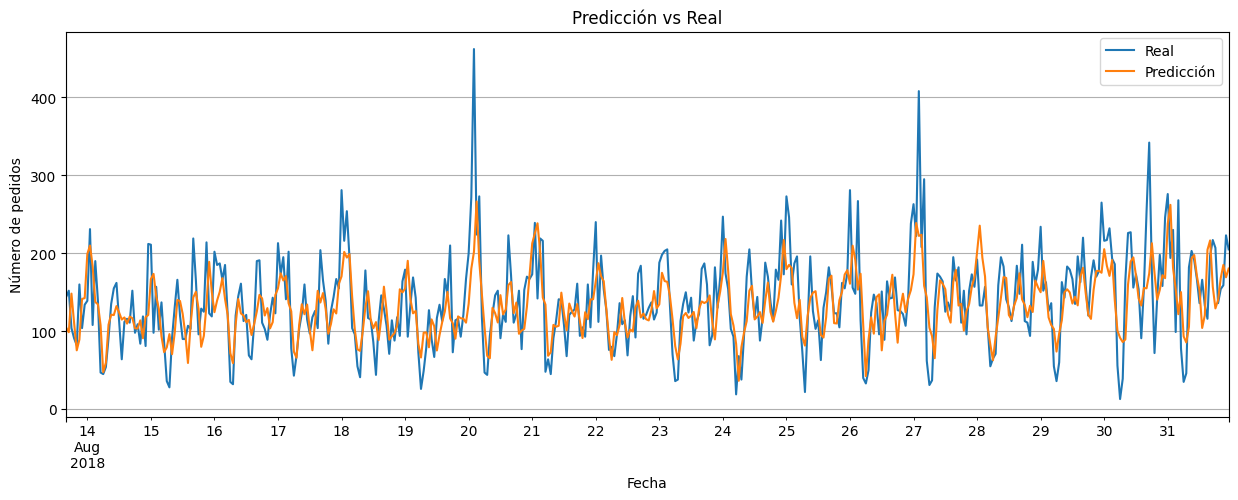

In [9]:

# Evaluación

rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE en conjunto de prueba: {rmse:.2f}')

# Visualización
plt.figure(figsize=(15,5))
y_test.plot(label='Real', legend=True)
pd.Series(y_pred, index=y_test.index).plot(label='Predicción', legend=True)
plt.title('Predicción vs Real')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.grid()
plt.show()

**Observaciones**

El resultado del RMSE del conjunto de prueba fue del 45.41 con 23 desfases. Esto quiere decir que en promedio, el modelo está cometiendo un error de aproximadamente 45 pedidos al predecir la cantidad de pedidos de taxis por hora.
Podríamos intentar con otros desfases.

Por lo que no está nada mal vs los 48 de límite permitido. 

In [10]:
# Verificación con otros modelos

models = {
    'Árbol de Decisión': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=200, depth=6, verbose=False, random_state=42),
    'LightGBM': LGBMRegressor(n_estimators=200, max_depth=7, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=200, max_depth=6, random_state=42, n_jobs=-1)
}

# Evaluación de modelos
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    results.append((name, rmse))
    print(f'{name} - RMSE: {rmse:.2f}')

# Comparación final
results_df = pd.DataFrame(results, columns=['Modelo', 'RMSE']).sort_values(by='RMSE')
print('\nComparación Final:')
print(results_df)

Árbol de Decisión - RMSE: 66.24
Random Forest - RMSE: 44.29
CatBoost - RMSE: 43.87
LightGBM - RMSE: 42.68
XGBoost - RMSE: 46.67

Comparación Final:
              Modelo       RMSE
3           LightGBM  42.680290
2           CatBoost  43.866010
1      Random Forest  44.289440
4            XGBoost  46.674261
0  Árbol de Decisión  66.242366


In [ ]:
# Gráfico comparativo
results_df = results_df.sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(10, 5))
plt.bar(results_df['Modelo'], results_df['RMSE'])
plt.title('Comparación de Modelos - RMSE en Conjunto de Prueba')
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Observaciones**

Tras entrenar y evaluar cinco modelos diferentes para la predicción de pedidos de taxis, se obtuvieron los siguientes resultados en términos de RMSE en el conjunto de prueba:

Modelo	RMSE
LightGBM	42.68
CatBoost	43.86
Random Forest	44.28
XGBoost	46.67
Árbol de Decisión	66.24

1. LightGBM obtuvo el mejor desempeño, con un RMSE de 42.68, siendo el único modelo capaz de predecir con un error promedio inferior a 45 pedidos. Esto indica que el modelo es el más adecuado para este problema bajo las condiciones actuales.
2. CatBoost y Random Forest también presentaron un rendimiento competitivo, ambos con RMSE por debajo del umbral crítico de 48, exigido por el proyecto. Estos modelos podrían considerarse opciones secundarias viables.
3. XGBoost mostró un desempeño inferior al esperado en comparación con otros modelos de boosting, posiblemente debido a la sensibilidad del modelo a los hiperparámetros o al tamaño del conjunto de entrenamiento.
4. El Árbol de Decisión fue el modelo con peor desempeño, con un RMSE de 66.24, lo que evidencia su limitada capacidad de generalización frente a modelos ensamblados como Random Forest o los algoritmos de boosting.



**Conclusiones Generales**

| Modelo               | RMSE Aproximado |
| -------------------- | --------------- |
| LightGBM             | 42.68           |
| CatBoost             | 43.86           |
| Random Forest        | 44.28           |
| XGBoost              | 46.67           |
| Árbol de Decisión    | 66.24           |
| Serie Temporal (Lag) | 45.41           |

1. El modelo de serie temporal (regresión lineal con desfase) logró un rendimiento competitivo, con un RMSE de 45.41, muy cercano a CatBoost y apenas detrás de LightGBM.
2. LightGBM y CatBoost lograron mejorar ligeramente el rendimiento del modelo de serie temporal, aunque no de manera drástica. Esto sugiere que el enfoque simple de desfase, aunque básico, es bastante eficaz para este problema.
3. Modelos avanzados de ensamblado (LightGBM, CatBoost, Random Forest) lograron:
    * Capturar patrones no lineales.
    * Aprovechar mejor las relaciones entre las variables de entrada (lags).

4. El modelo de regresión lineal es más simple y rápido de entrenar, pero menos flexible ante relaciones complejas, motivo por el cual los modelos de boosting lo superan.

**Conclusión Comparativa**

El modelo LightGBM es el mejor en cuanto a precisión, pero el modelo de serie temporal basado en regresión lineal ofrece una solución más simple, interpretable y bastante precisa, lo que puede ser útil si se prioriza transparencia o facilidad de implementación.

Para producción o decisiones críticas, el uso de LightGBM o CatBoost es recomendable, especialmente si se busca la máxima precisión.

El modelo de serie temporal puede considerarse un modelo base sólido y explicativo, pero con margen de mejora cuando se utilizan algoritmos más sofisticados.
